# Sentiment Analysis 

For this task, I build a model to predict the sentiment of movie reviews from the Stanford Sentiment Treebank binart classification dataset. This dataset consists of reviews labelled 1 for positive and 0 for negative.

This analysis is structured so that answers to A, B and C can be run separately. 


In [1]:
#import modules
import pandas as pd 
import numpy as np 


%matplotlib inline

import matplotlib.pyplot as plt

plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 20})


import sklearn

from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

from sklearn.model_selection import train_test_split as split
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer





from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB

import time

from sklearn.pipeline import Pipeline

In [2]:

class Dataset(object):
    """
    A helper data structure to store the images (X) and labels (y) of a dataset.
    """
    def __init__(self):
        self.X = None
        self.y = None


In [3]:
#get data
path = '/Users/user/AE2/S/train.tsv'
path2 = '/Users/user/AE2/S/dev.tsv'

train = pd.read_csv(path, sep='\t', usecols=['sentence','label'])
dev = pd.read_csv(path2, sep='\t', usecols=['sentence', 'label'])

train_x = train['sentence'].values
train_y = train['label'].values

dev_x = dev['sentence'].values
dev_y = dev['label'].values

#work out +/- split in train

ans = (len(train.loc[train.label ==1])/len(train)*100)

print(f'{ans:.2f}% positive, {(100-ans):.2f}% negative samples in training set')



55.78% positive, 44.22% negative samples in training set


The training set has 55.78% positive reviews, meaning the baseline score for a model that predicts all 1s would score 55.78%. 

# A) Vectorization

This task requires that I build a model to predict the sentiment (either positive or negative) of movie reviews. To do so, I first must transform the text input into numerical data for processing. The simplest means of doing this is to create a dictionary of words with term frequencies. First, the phrases must be tokenized into words, and then encoded as integers or floats to input into an algorithm.

A Bag-of-Words model (BoW) disregards all grammar and structure and implements a simple count of all words in the document, where each word is assigned a unique number. By adding the parameter n_grams = (1,2) it also encodes as tokens of 2 words as well as one, which improves performance by adding some context to phrases like ‘not bad’, but as demonstrated below the higher the number of grams the more features we have, making processing slower.

Once fit, the encoder can be applied to other documents using .transform(). 

I compare this count based vectorizer with TFIDF (Term Frequency – Inverse Document that calculates term frequency, weighted in terms of frequency within the document (indicating importance to the text), and downscaled by term frequency outside of the documents (indicating less importance to the text). 

I compare CountVectorizer with two forms of the TFIDFVectorizer, with and without stopwords. Since stopwords like ‘the’ don’t add meaning to the text they can be removed. The min_df has been set to 3 which means the terms must appear in minimum 3 documents, which also reduces the number of features. 





In [4]:
#test train split data
        
train = Dataset()
test = Dataset()

train.X, test.X, train.y, test.y = split(train_x, train_y,
                                        test_size = 0.2, random_state=1)



In [5]:
#compare vectorizers
vectorizers = {
    'CV': CountVectorizer(ngram_range=(1,2)),
    
    'tfidf': TfidfVectorizer(ngram_range=(1,2), min_df =2),
    
    
    
    'tfidf stopwords': TfidfVectorizer(stop_words="english", 
                                                                      min_df=2, 
                                                                      ngram_range=(1,3)),
   
    
    
}

vecs = []

for name, vectorizer in vectorizers.items():
    #fit to data
    vectorizer.fit(train.X)
    
    train.V=vectorizer.transform(train.X)
    test.V = vectorizer.transform(test.X)
    
    #LR model to compare
    
    model_lr = LogisticRegression(max_iter=1000).fit(X=train.V, y=train.y)
    
 
    train_score = round(model_lr.score(train.V, train.y), 4)*100
    test_score = round(model_lr.score(test.V, test.y)*100, 2)
    std = round(((train_score - test_score)**0.5), 2)
    features = len(vectorizer.get_feature_names())
    
    #add to list
    vecs.append([name,features, train_score, test_score, std])



In [6]:
#create df of results
vecs = np.array(vecs)
frame = pd.DataFrame(vecs, columns =['name','features', 'train %', 'test %', '+-std'])
frame.set_index('name')

,features,train %,test %,+-std
name,,,,
CV,78884,98.21,92.04,2.48
tfidf,69929,95.35,90.89,2.11
tfidf stopwords,87721,94.8,89.93,2.21


My results show that which vectorizer we use impacts the performance of the model. While the score is highest for CV, the variance between the train and test sets suggests that the output is overfit to the training data, meaning it is not flexible enough to perform as well on unseen data. Because of this, I the tfidf vectorizer seems best for my purposes, with >90 accuracy on train and test, low variance and fewer features than CV.  My results show that which vectorizer we use impacts the performance of the model. While the score is highest for CV, the variance between the train and test sets suggests that the output is overfit to the training data, meaning it is not flexible enough to perform as well on unseen data. Because of this, I the tfidf vectorizer seems best for my purposes, with >90 accuracy on train and test, low variance and fewer features than CV.  

# B) Model Selection 

In this section I compare the efficiency and accuracy of some models. I use the entire test set for this section as I use cross validation with 8 folds. Cross-validation means that all the data can be used for test and train and an average score is computed.  

SciKit Learn offers many classifiers to choose from. The three I have included have been chosen for their speed and their accuracy for binary classifications.

1. Logistic Regression 

Divides up the problem space by a sigmoid function and predicts labels for categorical dependent variables, so is well suited to binary classification. LR is the slowest model I consider.

2. Multinomial Naïve Bayes


Based on Bayes theorem prediction with the naive assumption of conditional independence. Is similar to LR and performs similarly but simplifies using assumptions to give a fast, highly simplified model. Is quicker than LR and uses less computational power. Can be tuned to give higher accuracy and correct for the initial assumptions for simplicity. 

3. SVM 

SVM requires more computational power than NB but performs the fastest and best of my three model choices. It also divides the decision space like LR, but tries to find a line with the ‘best’ margins to avoid misclassification. LR could change the decision boundaries by changing weights. LinearSVM performs SVM with a 'linear' kernel parameter. 

In [7]:
# apply vectorizer to all train 
vect = TfidfVectorizer(ngram_range=(1,2), min_df =2)
                       
train_XV = vect.fit_transform(train_x)

In [8]:
# choose estimators 
estimators ={
    'Log Regression:': LogisticRegression(max_iter=1000),
    'Naive Bayes:': MultinomialNB(),
    'SVC:': LinearSVC(max_iter=10000),
    
        
}

#set number of folds for cross validation 
folds = KFold(n_splits=5, random_state=1, shuffle=True)

results = []

names = []
for name, classifier in estimators.items():
    start = time.time() #timer
    scores = cross_val_score(classifier,
                            X=train_XV,
                            y=train_y,
                                  cv=folds)
    end = time.time() - start
    
    
    
    results.append(scores)
    names.append(name)
    msg= (f'{name:20s}:{scores.mean():.2%},+- {scores.std():.2}, [time:{end:.2f}s]')
    print(msg)
    


Log Regression:     :90.73%,+- 0.0021, [time:7.40s]
Naive Bayes:        :90.60%,+- 0.0012, [time:0.12s]
SVC:                :92.68%,+- 0.0024, [time:1.77s]


The results show similar scores for the classifiers, although LR is considerably slower than the others. NB is fastest by far and could be made more accurate with tuned hyperparamters. SVM has the highest scores, lowest std and fastest performance, although all models perform similarly well across the board.  I have made a box and whisker plot to visualise the performance of each classifier, that shows that SVC is the best performing. 

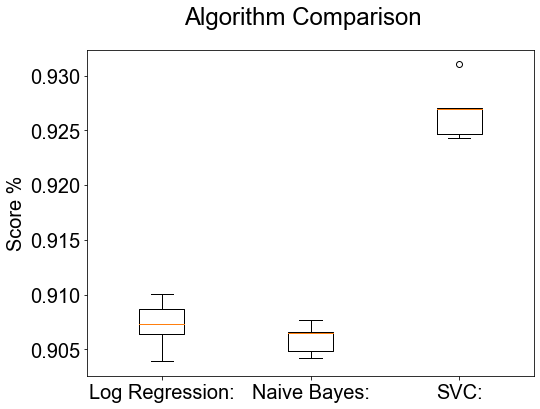

In [9]:
#plot results 


fig = plt.figure(figsize = (8,6))



fig.suptitle("Algorithm Comparison") #set title
ax = fig.add_subplot(111)

plt.boxplot(results) #box plot
ax.set_xticklabels(names)
ax.set_ylabel('Score %')


plt.show()

# C) Tune HPs

I can now tune some of the hyperparameters to improve the fit of my model. GridSearchCV allows to search through the hyperparameter space to compute the optimum cross validation score. Since this is computationally expensive, the number of parameters to search through must be limited. HalvingGridSearch can improve the speed for many variables.

I have made a pipeline of steps so that I can tune the parameters for the vectorizer and model together and use the same cv over the entire data set. I also include some more options for the grid search in comments, but the computation time to compare all would be too large to process them all at once. I have input the results of the gridsearch into a variable below so that it doesn't have to retrain every time. 


Also, not all parameters can occur together so they might have to be separated. 
LinearSVC is the same as SVC but with parameter kernel = ‘linear’, it is more flexible in choices of penalties including l1, l2 and loss. penalty l1 and hinge are not supported together so tests must separate them. 

C is a regularisation parameter determining the margins for misclassification. In this search the default scores for C are optimal, the optimal penality is l1, which means loss  is squared hinge and dual must be false

: {'clf__dual': False, 'clf__loss': 'squared_hinge', 'clf__penalty': 'l1'}


I also search for the optimal max document frequency and n gram ranges from 1-3 word tokens.

Code can be uncommented to exlpore more options but performing all at once will take a long time. Since parameter tuning doesn't improve the accuracy by much it might be worth looking into tuning a different model, for example NB, since tuning may have a greater impact on accuracy.



In [12]:
#create pipeline of steps 


pipeline = Pipeline([

    ('vect', TfidfVectorizer()),
    ('clf', LinearSVC(max_iter=10000)),
])

#set parameters for grid search 
params = [
    #'vect__max_df': (0.5, 0.75, 1.0), #max doc freq

    #'vect__ngram_range': ((1, 2), (1,3)),  # unigrams or bigrams
    
     #'clf__C': [1,10, 100], #regularisation
    
     #'clf__loss': ['hinge', 'squared_hinge']}, #loss function
    
    {'clf__loss': ['squared_hinge'],
     
     'clf__dual': [False],
     
    'clf__penalty': ['l1']}, #penalty function
    
    {
     'clf__loss': ['hinge'],
     
     'clf__dual': [True],
     'clf__penalty': ['l2']
     
    }

]

    
#Grid search for best parameters this is too long

grid_search = GridSearchCV(pipeline, params, cv=5, refit=True, verbose =1)
model2 = grid_search.fit(train_x, train_y)
print(grid_search.best_params_)



Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   36.8s finished


{'clf__dual': False, 'clf__loss': 'squared_hinge', 'clf__penalty': 'l1'}


# Tuning Results 

I have taken the best result from my tuning and put into pipeline_with to evaluate its performance. My testing shows that tuning improved Avg score accuracy from 81.54% to Avg score accuracy 83.6%. This model would place 17th on the leaderboard at https://gluebenchmark.com/leaderboard.

- Pipeline with no hyperparameter tuning Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.76      0.80       428
           1       0.79      0.87      0.83       444

    accuracy                           0.82       872
   macro avg       0.82      0.81      0.81       872
weighted avg       0.82      0.82      0.81       872

Avg score accuracy 81.54%
NEGATIVE
NEGATIVE
POSITIVE
- Pipeline with tuning Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.83       428
           1       0.84      0.84      0.84       444

    accuracy                           0.84       872
   macro avg       0.84      0.84      0.84       872
weighted avg       0.84      0.84      0.84       872

Avg score accuracy 83.60%
NEGATIVE
NEGATIVE
POSITIVE


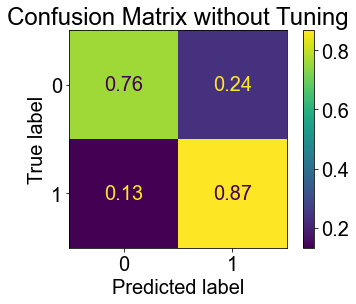

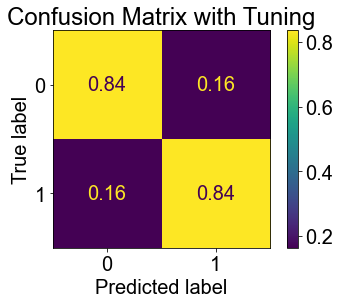

In [11]:
#Without parameter tuning

pipeline = Pipeline([

    ('vect', TfidfVectorizer()),
    ('clf', LinearSVC() )  ])


pipeline_with = Pipeline([

    ('vect', TfidfVectorizer(ngram_range =(1,3),  max_df=0.5)),
    ('clf', LinearSVC(C=1, dual=False, loss='squared_hinge', penalty='l1'))
])


    
model3 = pipeline.fit(train_x, train_y)

pred3 = model3.predict(dev_x)

print('- Pipeline with no hyperparameter tuning Classification Report:')
      
print(classification_report(dev_y, pred3))


    
disp = plot_confusion_matrix(model3, dev_x, dev_y, normalize ='true')
disp.ax_.set_title('Confusion Matrix without Tuning')


print(f'Avg score accuracy {model3.score(dev_x, dev_y):.2%}')

test_sentences = ['it wasnt bad at all', 'it was good but the ending was boring', 'it was so much better than the first']

predictions = model3.predict(test_sentences)

for prediction in predictions:
    
    if prediction >0:
        print('POSITIVE')
    elif prediction==0:
        print('NEGATIVE')
        

model4 = pipeline_with.fit(train_x, train_y)

pred4 = model4.predict(dev_x)

print('- Pipeline with tuning Classification Report:')

print(classification_report(dev_y, pred4))




print(f'Avg score accuracy {model4.score(dev_x, dev_y):.2%}')

disp2 = plot_confusion_matrix(model4, dev_x, dev_y, normalize = 'true')


disp2.ax_.set_title('Confusion Matrix with Tuning')

predictions4 = model4.predict(test_sentences)

for prediction in predictions:
    
    if prediction >0:
        print('POSITIVE')
    elif prediction==0:
        print('NEGATIVE')
        


# Reports 

Finally, I assess the performance of my model with a classification report and a confusion matrix. 

The cofusion matrix provides a visualisation of the distribution of correctly and incorrectly classified labels. I compare before and after paramater tuning. The confusion matrix shows that tuning has helped to reduce the number of false positives, improving overall accuracy but also affecting the number of false negatives by a slight increase.

To test this, I have included two test sentences that are positive but contain negative language. An improved model would be able to handle these sentences. By taking more context into account in the vectorizing stage I might be able to account for this nuance. Unfortunately the tuning doesn't overcome this problem at this stage. 

The confusion matrix shows that the model predicts more false positives. As I show above, the data is not evenly split between positive and negative, which might influence the prediction. To try and improve this model I could create out of the original data set a balanced training set. 

The classification report provides scores precision, that scores how well a classifier labels predicts positives, and recall the fraction of correctly identified positives. The F1 score takes both of these into account so gives a beter insight into performance than accuracy to compare models. We can see that the tuning improves the f1 score for both positive and negative predictions.


# Ethical Implications 

The risks of misclassification for models poses ethical issues. An accuracy of 83.6% means that many of the reviews will be misclassified. This problem will also become worse if the input data is not representative.  Skewing the sentiment of a movie review because, for example, the kind of language used varies, might have negative consequences for the output and mean that some movies are ranked worse than they should be. Since language often varies between different groups of people, for example, higher qualified professionals might use more complex language, while say, a teenager might use more slang. It is important for the model to be able to deal with both to avoid bias. A larger dataset should theoretically be more accurate but this is not necessarily the case. It has to be representative of the broader population to aviod this kind of bias. 

Human insight will always be required to check over for this kind of bias in code. Ultimately, it is also only humans that can be held accountable for the damages that might be caused by biased algorithms. 

Finally, the binary nature of this sentiment analysis is overly coarse-grained. While it is useful for classifying these reviews, the natural language text carries much more information. So this model is an oversimplification of reality that might distort how things really are. Adding more fine-grained distinctions like a neutral category might help to overcome this problem and could also improve performance. 

# References 

[SciKit Learn Documentation](https://scikit-learn.org/dev/versions.html)

[SciKit Learn Working with text data](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)

[Algorithmic Accountability (Shah 2018)](https://royalsocietypublishing.org/doi/10.1098/rsta.2017.0362)

[Data Science From Scratch Handbook](https://github.com/dwelcaslu/machine-learning-books/blob/master/Data%20Science%20from%20Scratch-%20First%20Principles%20with%20Python.pdf)









In [13]:
import io
from nbformat import current
filepath = 'AE27.ipynb'
with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')
#markdown count
md_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        md_count += len(cell['source'].strip().split())
print(f' Words in MarkDown: {md_count}')
#heading count
head_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "heading":
        head_count += len(cell['source'].replace('#', '').strip().split())
print(f' Words in Headings: {head_count}')
#codecount
code_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "code":
        code_count += len(cell['input'].replace('#', '').strip().split())
print(f' Words in code: {code_count}')
print(code_count + head_count + md_count)

 Words in MarkDown: 1605
 Words in Headings: 6
 Words in code: 659
2270
